# Logistics Optimization

In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext blackcellmagic
%matplotlib inline

In [2]:
import collections
import json
import math 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from relearn.env import SimpleLogistics, Warehouse

# Logistics Provider Environment

In this example, we simulate the item delivery of a logistics provider.
We define the problem as **Dispatch items from arbitrary sellers to a logistics provider's distribution center (warehouse) where the logistics provider delivers the items to their destinations**.

To make our problem simpler, we set following assumptions:
- The distribution center operates independently so that we can define the single warehouse in our simulation.
- Items are dispatched and stored into the warehouse every day with a fixed (transportation) cost.
- Each item has one of two types of delivery: 2-day and 7-day delivery.
- There is no penalty for the dispatch failure caused by full-inventory, but there is a penalty for the late delivery.
- Items of the same destination are grouped and shipped together.

> TODO: Currently, this environment doesn't consider the route-optimization.

Here are our environment parameters:

In [3]:
NUM_EPISODES = 100  # days

# Average number of items to dispatch per episode
AVG_DEMAND = 20

# Number of item delivery destinations
NUM_DESTINATIONS = 10

# Distribution center capacity
WAREHOUSE_CAPACITY = 100

# Max items that can be delivered to the same location at a time
DELIVERY_CAPACITY = 5 

SEED = 1234

In [22]:
env = SimpleLogistics(
    T=NUM_EPISODES,
    capacity=WAREHOUSE_CAPACITY,
    delivery_capacity=DELIVERY_CAPACITY,
    num_destinations=NUM_DESTINATIONS,
    demand_fn=AVG_DEMAND,
    seed=SEED,
)
env.render('df').head(5)

/home/jumin/miniconda3/envs/relearn/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


,t,dest,due,price,penalty,dest_cost,dest_cap
0,0.0,7.0,2.0,0.5,0.25,0.801872,4.0
1,0.0,0.0,2.0,0.5,0.25,0.191519,1.0
2,0.0,9.0,2.0,0.5,0.25,0.875933,2.0
3,0.0,1.0,2.0,0.5,0.25,0.622109,3.0
4,0.0,5.0,2.0,0.5,0.25,0.272593,4.0


Text(0, 0.5, 'Demand')

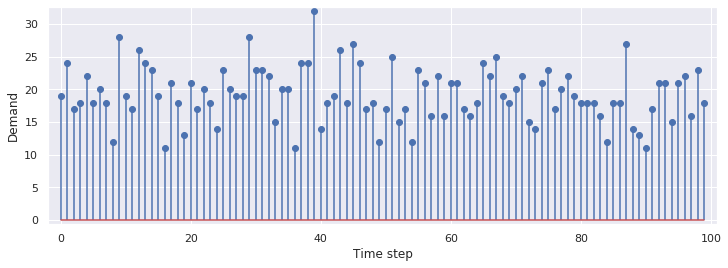

In [23]:
# Visualize demand functions
env.reset(SEED)
plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.stem([len(env.demand()) for _ in range(NUM_EPISODES)], use_line_collection=True)
plt.xlabel("Time step")
plt.ylabel("Demand")

In [24]:
# Delivery costs to each destination area
env.warehouse.delivery_costs

array([0.19151945, 0.62210877, 0.43772774, 0.78535858, 0.77997581,
       0.27259261, 0.27646426, 0.80187218, 0.95813935, 0.87593263])

In [25]:
# Sample action
env.action_space.sample()

array([67, 13,  7, 83, 66, 55, 83, 11, 79, -1, 36, 61, 13, 69, 41, 88, 67,
       82, 31, 87, 67, 71, 17, 69, 21, 66, 55, 65, 99, 96, 67,  2, 18, 56,
       61, 27, 87, 38, 47, 69, 87, 21, 26, 37, 46, 36, 27, 49, 16, 36, 85,
       37, 78, 32,  4, 64, 22, 65,  8, 96, 57, 73, 36, 54, 69, 36,  3, 19,
        2,  1, 27, 40, 80, 49, 66,  2, 77, 72, 75, 25, 88, 55, 99,  1, 41,
       85, 38, 50, 70, 78, 73, 94, 12, 72,  4, 98, 87, 74, 26,  0])

Text(0, 0.5, 'Profit')

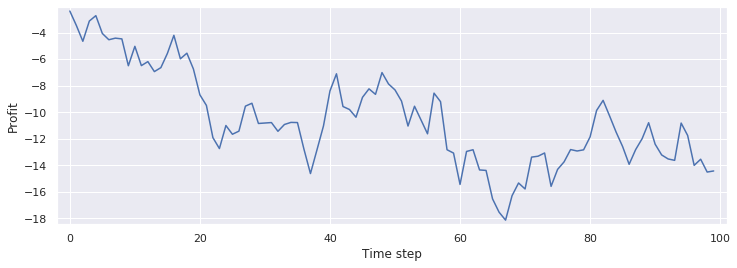

In [39]:
# Random action
env.reset(SEED)
done = False
rewards = []
while not done:
    _, reward, done, info = env.step(env.action_space.sample())
    rewards.append(reward)

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

Text(0, 0.5, 'Profit')

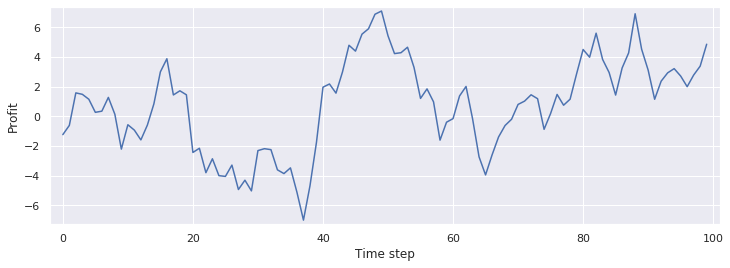

In [40]:
# First come first serve
env.reset(SEED)
done = False
rewards = []
while not done:
    delivery = list(range(len(env.warehouse.inventory)))
    _, reward, done, info = env.step(delivery)
    rewards.append(reward)
#     print(info['num_items_failed_to_deliver'])

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

In [ ]:
# TODO plot demands, delivery, penalty, etc. together


In [ ]:
# env.close()

# Simple Policy

In [102]:
class WaitAndDeliverPolicy:
    def __init__(
        self,
        due,
        capacity,
        delivery_capacity,
    ):
        """Wait to collect as many items as possible before delivery.
        Deliver when there are due items or reached to delivery_capacity_limit
        or capacity_limit.
        """
        self.due = due
        self.capacity = capacity
        self.delivery_capacity = delivery_capacity

    def action(self, state_df):
        """Check inventory, select items to deliver ():
        """
        full_capacity = len(state_df)
        
        # remove empty
        df = pd.DataFrame(state_df.loc[state_df['price'] > 0.0])
        df['due-t'] = df['due'] - df['t']
        
        if len(df) > self.capacity:
            pass  # Try to deliver all 
        else:
            # deliver the items close to the due date and other items that have the same destinations.
            due_items = df.loc[df['due-t'] < self.due]
            areas = set(due_items['dest'].unique())
            
            # also, include areas where the delivery capacity is full
            dest_cnt = df.groupby('dest').count()['t']
            areas.update(dest_cnt.loc[dest_cnt > self.delivery_capacity].index)
            
            # select the items for those areas
            df = df.loc[df['dest'].isin(areas)]
        
        return np.array(df.sort_values('due-t').index)


In [103]:
wd_policy = WaitAndDeliverPolicy(
    due=1.0,
    capacity=int(WAREHOUSE_CAPACITY * 0.8),
    delivery_capacity=int(DELIVERY_CAPACITY * 0.8),
)

Text(0, 0.5, 'Profit')

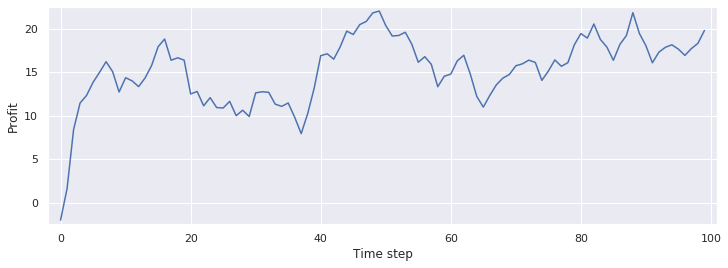

In [127]:
env.reset(SEED)
done = False
rewards = []
while not done:
    action = wd_policy.action(env.render('df'))
    _, reward, done, info = env.step(action)
    rewards.append(reward)
#     print(info['num_items_failed_to_deliver'])

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

### Optimizing (s, Q)-policy parameters using Facebook Ax

In [ ]:
from ax import optimize

def func(p):
    policy = SQPolicy(
        p['factory_s'], 
        p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    return np.mean(simulate(env, policy, num_episodes = 30))

best_parameters, best_values, experiment, model = optimize(
        parameters=[
          { "name": "factory_s",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "factory_Q",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "w1_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w1_Q",        "type": "range",  "bounds": [0.0, 20.0], },  
          { "name": "w2_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
          { "name": "w3_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
        ],
        evaluation_function=func,
        minimize=False,
        total_trials=200,
    )

In [ ]:
display(best_parameters)
display(best_values)

In [ ]:
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()
policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, policy_sQ, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

In [ ]:
# tracing the winning (s,Q)  policy
env = SupplyChainEnvironment()
transitions_sQ = simulate_episode(env, policy_sQ)
visualize_transitions(np.array(transitions_sQ))

### Optimization of (s, Q)-policy parameters using brute force search

In [ ]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1, 
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

# Optimizing the Policy Using Reinforcement Learning / RLlib

In [ ]:
import numpy as np
import gym
from gym.spaces import Box

import ray
from ray import tune
from ray.rllib.utils import try_import_tf

import ray.rllib.agents.ddpg as ddpg
from ray.tune.logger import pretty_print

tf = try_import_tf()

# gym environment adapter
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, shape=(self.supply_chain.warehouse_num + 1, ), dtype=np.int16)
        self.observation_space = Box(-10000, 10000, shape=(len(self.supply_chain.initial_state().to_array()), ), dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}
    
ray.shutdown()
ray.init()

def train_ddpg():
    config = ddpg.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["actor_hiddens"] = [512, 512] 
    config["critic_hiddens"] = [512, 512]
    config["gamma"] = 0.95
    config["timesteps_per_iteration"] = 1000
    config["target_network_update_freq"] = 5
    config["buffer_size"] = 10000
    
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    for i in range(200):
        result = trainer.train()
        print(pretty_print(result))
        checkpoint = trainer.save()
        print("Checkpoint saved at", checkpoint)

train_ddpg()

# Analysis and Debugging of the Policy Produced by RLlib

In [ ]:
import json

def load_policy():
    log_dir = ".../ray_results/DDPG_SimpleSupplyChain_2020-01-23_20-51-479cn5z0i0" # this path needs to be set manually
    checkpoint_id = "200"
    with open(f"{log_dir}/params.json", "r") as read_file:
        config = json.load(read_file)
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    trainer.restore(f"{log_dir}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer.get_policy()

policy = load_policy()

# tracing the policy
env = SupplyChainEnvironment()
state = env.initial_state()
transitions_rl = []
for t in range(env.T):
    action = policy.compute_single_action( state.to_array() , state=[] ) 
    action_obj = Action(env.warehouse_num)
    action_obj.production_level = action[0][0]
    action_obj.shippings_to_warehouses = action[0][1:]
    state, reward, _ = env.step(state, action_obj)
    transitions_rl.append([state, action_obj, reward])

In [ ]:
# tracing the policy
visualize_transitions(np.array(transitions_rl))